## Anomaly Detection

In this notebook we'll see how to apply deep neural networks to the problem of detecting anomalies.  Anomaly detection is a wide-ranging and often weakly defined class of problem where we try to identify anomalous data points or sequences in a dataset.  When dealing with time series specifically (such as a sensor or collection of sensors on a piece of equipment), defining something as anomalus needs to take into account temporal dependencies.  This is a challenge that deep learning models are fairly well suited to handle.  We'll start with a simple time series of sensor readings and see how to construct an autoencoder using LTSM's that predict future time steps in the series.  We'll then see how to use the distribution of the model errors to identify points in time that stand out as potentially being anomalus.

The dataset used for this example can be found [here](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv).  It's part of a collection of datasets that Numenta has hosted to showcase their own anomaly detection methods.

Let's start by getting some imports out of the way and reading the data into a data frame.

In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style()

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv')
data.shape

(22695, 2)

In [3]:
data.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


The data is very simple, just a series of timestamps and a value.  Many real-world problems will be much more complex than this (some industrial use cases might have hundreds or even thousands of variables) but the technique works the same no matter how many dimensions you're dealing with.  Since we only have one variable, let's plot it and see what it looks like.

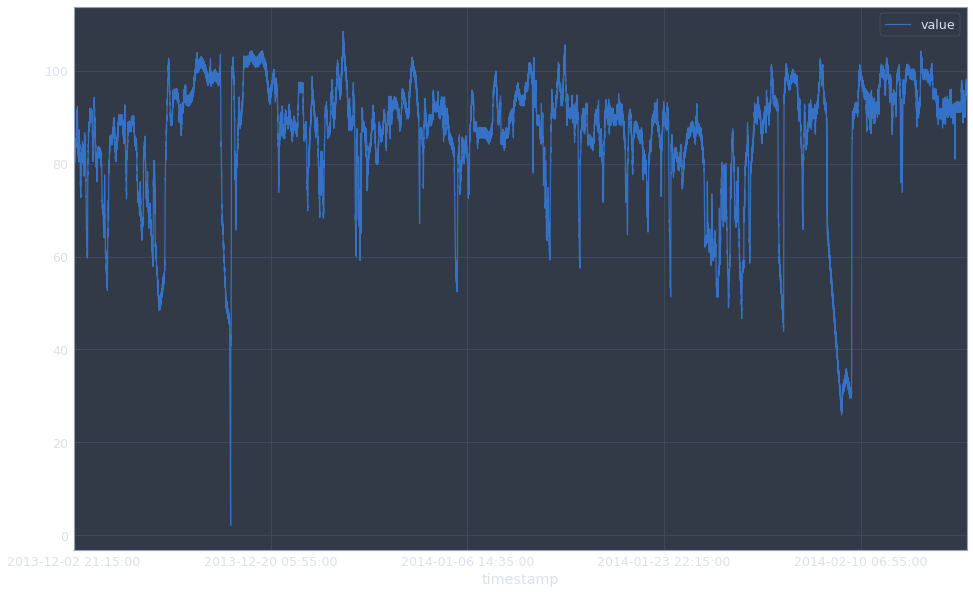

In [4]:
data.set_index('timestamp').plot(figsize=(16, 10))

Visually there are a number of spots that look like they might be outliers, but it's hard to tell.  In any case, the eye test certainly doesn't scale or have any statistical robustness behind it, so we need a better approach.  Anomaly detection is not natively a supervised learning problem in most cases, and even if labels are available, there's often so few events that it's hard to build a model from them.  We can turn it into a supervised learning problem though by building an autoencoder that just predicts the next step in the time series.  Start by massaging the data into a format that we can use and creating the typical training and validation sets.

In [5]:
from sklearn.model_selection import train_test_split

X = data['value'].values.reshape((len(data), 1))
y = data['value'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((20424, 1), (20424, 1), (2270, 1), (2270, 1))

In [6]:
X[1, :], y[0, :]

(array([74.935882]), array([74.935882]))

All we did is offset the X and y arrays by one (in the opposite direction) so each slice of y is the next value of the same slice of X.  We're not done though because we want the autoencoder to "see" more than one of the previous time steps so it can build a representation of the patterns in the data.  Start by setting up a few variable such as the number of time steps to model.

In [7]:
n_timesteps = 48
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]

Now we need to transform the input arrays so that each "row" contains an array of the previous values in the series, up to our number of time steps.  Keras expects the time slices as the 2nd dimension in the array so we'll take care of this now.  We also need to adjust the labels array to account for the fact that we're starting at a later time slice now.

In [8]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples + 1)]
X_train = np.concatenate(X_train_list, axis=0)
y_train = y_train[n_timesteps-1:, :]

X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val = np.concatenate(X_val_list, axis=0)
y_val = y_val[n_timesteps-1:, :]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((20377, 48, 1), (20377, 1), (2223, 48, 1), (2223, 1))

Now that we have the data ready to go, we can proceed with defining the autoencoder.  There is nothing particular in the architecture itself that makes a network an autoencoder, it's just a function of the task that we've set the network up to perform.  That said, they typically have an "encoder-decoder" pattern which we've implemented using LSTM layers below.  The output is just a linear activation on a dense layer with size equal to the number of features.  Either absolute error or squared error should work.  This is just something that has to be experimented with.

I'll note that I spent zero time tuning this so don't get too absorbed in the details of this particular architecture.  It's going to vary a lot depending on the problem you're trying to solve.

In [9]:
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam

def Autoencoder(n_timesteps, n_features):
    i = Input(shape=(n_timesteps, n_features))
    
    x = LSTM(50, return_sequences=True)(i)
    x = Dropout(0.4)(x)
    
    x = LSTM(50)(x)
    x = Dropout(0.4)(x)

    x = Dense(n_features, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model

Using TensorFlow backend.


Always a good idea to look at the design and make sure it's doing what you expected.

In [10]:
model = Autoencoder(n_timesteps, n_features)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total para

Training is very straightforward.  The loss asymptotes on this dataset very quickly.  It's possible that 48 time steps isn't enough to really model patterns in the data, or maybe our architecture isn't sufficient, or maybe it's not even possible to do much better with just a single variable.  One of the challenges with anomaly detection is it's hard to even say what would constitute a "good" loss on this problem.  Remember our ultimate goal is not to predict the next time slice.  We're using this task as a way to model the data distribution which we'll use further downstream.

In [11]:
model = Autoencoder(n_timesteps, n_features)
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=10, verbose=1,
                    callbacks=None, validation_data=(X_val, y_val), shuffle=False)

Train on 20377 samples, validate on 2223 samples
Epoch 1/10
20377/20377 [==============================] - 10s 475us/step - loss: 43.0460 - val_loss: 12.0010
Epoch 2/10
20377/20377 [==============================] - 7s 336us/step - loss: 12.8038 - val_loss: 9.4660
Epoch 3/10
20377/20377 [==============================] - 7s 328us/step - loss: 12.7584 - val_loss: 9.5037
Epoch 4/10
20377/20377 [==============================] - 7s 342us/step - loss: 12.5310 - val_loss: 9.4008
Epoch 5/10
20377/20377 [==============================] - 7s 323us/step - loss: 12.5821 - val_loss: 9.4329
Epoch 6/10
20377/20377 [==============================] - 8s 369us/step - loss: 12.6675 - val_loss: 9.4203
Epoch 7/10
20377/20377 [==============================] - 7s 363us/step - loss: 12.5998 - val_loss: 9.4545
Epoch 8/10
20377/20377 [==============================] - 7s 331us/step - loss: 12.6180 - val_loss: 9.4370
Epoch 9/10
20377/20377 [==============================] - 7s 324us/step - loss: 12.6221 - val

Next we need to generate some predictions on the training data and calculate the error for each instance.

In [12]:
y_train_pred = model.predict(X_train)
y_train_pred.shape

(20377, 1)

In [13]:
from sklearn.metrics import mean_absolute_error
errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
len(errors)

20377

We now have a list of prediction errors from the model's training data.  The next step is to do something with these errors.  The general idea is that we can model the distribution of errors to capture the "normal-ness" of a given simple.  In other words, say we come up with a distribution where the mean is 10 and standard deviation is 5.  If we then had a new time slice that we run through the autoencoder and get an error of 11, we'd say that's probably not an anomaly because it's close to the mean.  However, if we get an error of 40 (i.e. the model is way off in it's prediction) then that's much more likely to be an anomaly.  One can imagine various different ways of employing this in a real-world system such as averaging recent errors over some period of time etc.

First, let's see what happens when we do a kernel density estimation in seaborn.  This will give us a good idea of what the shape of the distribution should look like.

/home/john/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


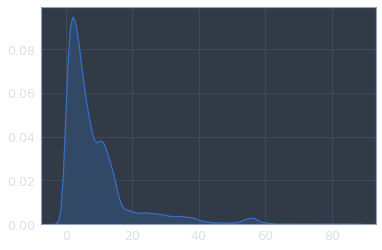

In [14]:
import seaborn as sb
sb.kdeplot(errors, shade=True)

The errors don't quite appear to be normally distributed as there's a bit of a fat tail on the right side.  If this was a real project I might try to find something that fits better, but I think a gaussian is close enough for this example.  Let's load up scipy and fit the errors to a normal distribution.

In [15]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(9.108284954559819, 10.442401924215941)

We've got a mean of 9.25 and a standard deviation of 10.2.  That gives us a starting point to figure out which time slices are potential anomalies.  From here it's somewhat subjective.  We have to make a determination on how much of an outlier a point needs to be before we say it could be an anomaly.  Is it two standard deviations?  Three?  Making this call is probably going to be project-specifc.  We can make a generic function for "scoring" an error though regardless of where the cutoff is.

In [16]:
def is_anomaly(error, mean, std, threshold):
    delta = np.abs(error - mean)
    multiple = delta / std
    if multiple < threshold:
        return 0
    else:
        return 1

We can now run new data through the autoencoder, score the resulting prediction to get an error, and determine if the new data represents a potential anomaly based on how far out in the distribution that error falls.  Let's see an example using the validation data.

In [17]:
y_val_pred = model.predict(X_val[:10, :, :])
val_errors = [mean_absolute_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
result = [is_anomaly(x, dist.mean(), dist.std(), 2) for x in val_errors]
print(result)

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]


We could also come up with a continuous scoring system using the cumulative density function.

In [18]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)

The higher the number, the more likely the sample is to be an anomaly.

In [19]:
result = [np.round(anomaly_score(x, dist), 4) for x in val_errors]
print(result)

[0.9972, 0.6592, 0.7765, 0.7504, 0.7755, 0.7101, 0.5185, 0.7756, 0.9958, 0.7567]
